In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit
import pandas as pd
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import widgets, interactive, VBox, Button, FloatSlider, FloatText, interactive_output, link
from IPython.display import display, clear_output
import numpy as np
from ipywidgets import Checkbox

#from uncertainties import ufloat
#import uncertainties.unumpy as unp

In [52]:
path = 'calibration.csv'
df = pd.read_csv(path)

In [53]:
df.head()

,Time,minutes,corr_conc,recovery,std_corrconc,rec_std
0,2021-11-15 14:29:07,0,0.0,0.0,0.0,0.0
1,2021-11-15 14:31:07,2,0.0,0.0,0.0,0.0
2,2021-11-15 14:33:07,4,0.0,0.0,0.0,0.0
3,2021-11-15 14:35:07,6,0.0,0.0,0.0,0.0
4,2021-11-15 14:37:07,8,0.0,0.0,0.0,0.0


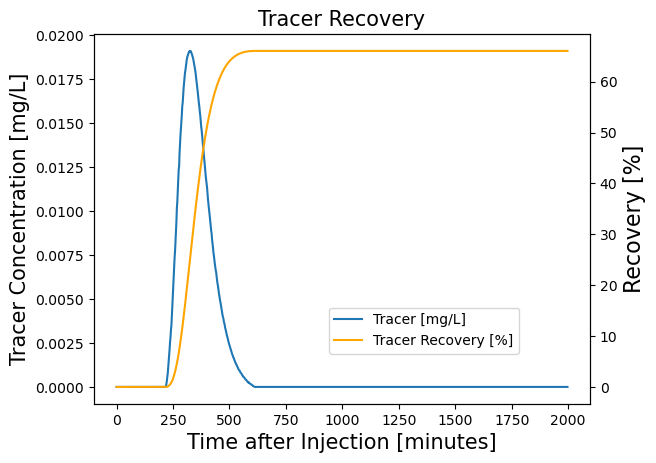

In [54]:
df = pd.read_csv('calibration.csv')

# plot df['corr_conc]
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df['minutes'], df['corr_conc'])
ax2.plot(df['minutes'], df['recovery'], color = 'orange')

ax.set_title("Tracer Recovery", fontsize=15)

ax.set_ylabel("Tracer Concentration [mg/L]", fontsize=(15))
ax.set_xlabel("Time after Injection [minutes]", fontsize=(15))
ax2.set_ylabel("Recovery [%]", fontsize=16)

fig.legend(['Tracer [mg/L]', 'Tracer Recovery [%]'], loc = 'lower right', bbox_to_anchor=(0.8, 0.2))



In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import widgets, interactive, VBox, Button, FloatSlider, FloatText, Checkbox, Dropdown
from IPython.display import display, clear_output

class OneDimensionalAdvectionDispersionModel:
    """
    A class representing a one-dimensional advection-dispersion model.
    
    This model simulates the transport of a solute through a porous medium, considering both advection 
    (transport due to flow) and dispersion (spreading due to diffusion and mechanical dispersion).

    Attributes:
    ----------
    real_data : DataFrame
        The real concentration data loaded from a CSV file.
    x : float
        Distance over which advection-dispersion occurs (in meters).
    m_in : float
        Mass input rate of the solute (in grams).
    Q : float
        Flow rate through the porous medium (in cubic meters per second).
    popt : ndarray
        Optimal parameters obtained from curve fitting.
    pcov : ndarray
        Covariance of the optimal parameters.
    fitted_line : ndarray
        Placeholder for the fitted concentration values.
    model_line : ndarray
        Placeholder for the manually adjusted concentration values.
    secondary_axis : str
        Unit for the secondary x-axis, either 'minutes' or 'hours'.
    fixed_x_range : tuple
        Fixed range for the x-axis.
    fixed_y_range : tuple
        Fixed range for the y-axis.
    fig : matplotlib.figure.Figure
        The figure object for plotting.
    ax : matplotlib.axes.Axes
        The axes object for plotting.

    Methods:
    -------
    return_real_data():
        Returns the real concentration data.
    return_manual_adjusted_model():
        Returns the manually adjusted model concentration values.
    return_fitted_model():
        Returns the fitted model concentration values.
    diff_fit(t, D, v, Q=None, m_in=None, x=None):
        Calculates the concentration values based on the advection-dispersion equation.
    initial_plot():
        Initializes the plot with real concentration data.
    fit_model(fit_m_in=False):
        Fits the advection-dispersion model to the real concentration data.
    plot_with_model(D, v, Q, m_in, x, fit_m_in=False):
        Plots the real data, manual fit, and automatic fit concentration values.
    add_secondary_xaxis():
        Adds secondary x-axis labels in minutes or hours below the primary x-axis.
    create_interactive_plot():
        Creates an interactive plot for adjusting the model parameters.
    """

    def __init__(self, real_data_file, x=300, m_in=2.05, Q=11e-3, secondary_axis='hours'):
        """
        Initializes a OneDimensionalAdvectionDispersionModel object.

        Parameters:
        ----------
        real_data_file : str
            The file path to the real data CSV file containing columns 'minutes' and 'corr_conc'.
        x : float, optional
            Distance over which advection-dispersion occurs (in meters). Default is 300 meters.
        m_in : float, optional
            Mass input rate of the solute (in grams). Default is 2.05 grams.
        Q : float, optional
            Flow rate through the porous medium (in cubic meters per second). Default is 0.011 m³/s.
        secondary_axis : str, optional
            Unit for the secondary x-axis, either 'minutes' or 'hours'. Default is 'hours'.
        """
        self.real_data = pd.read_csv(real_data_file)
        self.real_data['seconds'] = self.real_data['minutes'] * 60  # Convert minutes to seconds
        self.x = x
        self.m_in = m_in
        self.Q = Q
        self.popt = None
        self.pcov = None
        self.fitted_line = None
        self.model_line = None
        self.secondary_axis = secondary_axis

    def return_real_data(self):
        """
        Returns the real concentration data.

        Returns:
        -------
        DataFrame
            The real concentration data with columns 'minutes', 'corr_conc', and 'seconds'.
        
        Explanation:
        This function simply returns the real concentration data loaded from the CSV file.
        """
        return self.real_data
    
    def return_manual_adjusted_model(self):
        """
        Returns the manually adjusted model concentration values.

        Returns:
        -------
        ndarray
            The manually adjusted model concentration values.
        
        Explanation:
        This function returns the concentration values that were manually adjusted using the interactive sliders.
        """
        return self.manual_model_line

    def return_fitted_model(self):
        """
        Returns the fitted model concentration values.

        Returns:
        -------
        ndarray
            The fitted model concentration values.
        
        Explanation:
        This function returns the concentration values obtained by fitting the model to the real data.
        """
        return self.auto_model_line

    def diff_fit(self, t, D, v, Q=None, m_in=None, x=None):
        """
        Calculates the concentration values based on the advection-dispersion equation.

        Parameters:
        ----------
        t : ndarray
            Time values (in seconds).
        D : float
            Dispersion coefficient (in m²/s).
        v : float
            Velocity of the flow (in m/s).
        Q : float, optional
            Flow rate through the porous medium (in cubic meters per second). Default is the instance attribute Q.
        m_in : float, optional
            Mass input rate of the solute (in grams). Default is the instance attribute m_in.
        x : float, optional
            Distance over which advection-dispersion occurs (in meters). Default is the instance attribute x.

        Returns:
        -------
        ndarray
            The calculated concentration values (in g/m³).
        
        Explanation:
        This function computes the concentration of the solute over time using the advection-dispersion equation. 
        It considers the effects of both advection (transport by flow) and dispersion (spreading due to diffusion 
        and mechanical dispersion).
        """
        if Q is None:
            Q = self.Q
        if m_in is None:
            m_in = self.m_in
        if x is None:
            x = self.x

        term1 = m_in / Q
        term2 = x / (np.sqrt(4 * np.pi * D * t**3) + 1e-10)
        return term1 * term2 * np.exp(-((x - v * t)**2) / ((4 * D * t) + 1e-10))

    def initial_plot(self):
        """
        Initializes the plot with real concentration data.
        
        Explanation:
        This function sets up the initial plot with the real concentration data. It creates a figure and axes,
        plots the real data, and sets the x and y axis labels and title. The figure and axes are saved as instance
        attributes for later use.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        self.fig = fig
        self.ax = ax
        ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Data (Concentration, g/m³)', color='orange')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Concentration (g/m³)')
        ax.set_title('Concentration vs. Time')
        plt.legend()
        plt.close()

        self.fixed_x_range = (self.real_data['seconds'].min(), self.real_data['seconds'].max() * 1.2)
        self.fixed_y_range = (self.real_data['corr_conc'].min(), self.real_data['corr_conc'].max() * 1.2)

    def fit_model(self, fit_m_in=False):
        """
        Fits the advection-dispersion model to the real concentration data.

        Parameters:
        ----------
        fit_m_in : bool, optional
            Whether to fit the mass input rate (m_in). Default is False.
        
        Explanation:
        This function fits the advection-dispersion model to the real concentration data using non-linear
        least squares fitting. It can optionally fit the mass input rate in addition to the dispersion coefficient
        and velocity.
        """
        t = self.real_data['seconds'].values
        conc = self.real_data['corr_conc'].values

        if fit_m_in:
            p0 = self.D, self.v, self.m_in
            print('Initial guess for D, v, m_in: ', p0)
            self.popt, self.pcov = curve_fit(lambda t, D, v, m_in: self.diff_fit(t=t, D=D, v=v, m_in=m_in), t, conc, p0=p0)
        else:
            p0 = self.D, self.v
            self.popt, self.pcov = curve_fit(lambda t, D, v: self.diff_fit(t, D, v), t, conc, p0=p0)

        print(f"Fitted parameters: D = {self.popt[0]:.3f}, v = {self.popt[1]:.3f}" + (f", m_in = {self.popt[2]:.3f}" if fit_m_in else ""))

    def plot_with_model(self, D, v, Q, m_in, x, fit_m_in=False):
        """
        Plots the real data, manual fit, and automatic fit concentration values.

        Parameters:
        ----------
        D : float
            Dispersion coefficient (in m²/s).
        v : float
            Velocity of the flow (in m/s).
        Q : float
            Flow rate through the porous medium (in m³/s).
        m_in : float
            Mass input rate of the solute (in g).
        x : float
            Distance over which advection-dispersion occurs (in meters).
        fit_m_in : bool, optional
            Whether to fit the mass input rate (m_in). Default is False.
        
        Explanation:
        This function generates and displays the plot of the real concentration data along with the model predictions.
        It includes both the manually adjusted model (based on user inputs) and the automatically fitted model 
        (based on curve fitting). The plot shows the concentration as a function of time, and the secondary x-axis
        can be displayed in minutes or hours.
        """
        clear_output(wait=True)
        self.ax.clear()
        plt.close()

        seconds = self.real_data['seconds'].values
        t_values = np.linspace(seconds.min(), seconds.max(), 1000)
        c_values = self.diff_fit(t_values, D, v, Q, m_in, x)

        self.ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Data (Concentration, g/m³)', color='orange')
        self.ax.plot(t_values, c_values, label=f"Manual Fit (D: {D:.3e} m²/s, v: {v:.3e} m/s)", color='blue')

        if self.popt is not None:
            D = self.popt[0]
            v = self.popt[1]
            if fit_m_in:
                m_in = self.popt[2]
            else: 
                m_in = None

            fitted_values = self.diff_fit(t_values, D=D, v=v, m_in=m_in)
            legend_label = f"Automatic Fit (D: {self.popt[0]:.3e} m²/s, v: {self.popt[1]:.3e} m/s"
            if fit_m_in:
                legend_label += f", m_in: {self.popt[2]:.3e} g"
            legend_label += ")"
            self.ax.plot(t_values, fitted_values, label=legend_label, color='red')
            self.auto_model_line = fitted_values

        Dispersivity = D / v
        self.ax.text(0.92, 0.87, f'Dispersivity  : {Dispersivity:.3f} m', transform=plt.gcf().transFigure, fontsize=12, verticalalignment='bottom')

        self.ax.set_xlim(self.fixed_x_range)
        self.ax.set_ylim(self.fixed_y_range)
        self.ax.set_xlabel('Time (seconds)')
        self.ax.set_ylabel('Concentration (g/m³)')
        self.ax.set_title('1D Advection Dispersion Model')
        self.ax.legend()
        
        self.add_secondary_xaxis()

        display(self.fig)

        self.manual_model_line = c_values
        self.t_values = t_values

    def add_secondary_xaxis(self):
        """
        Adds secondary x-axis labels in minutes or hours below the primary x-axis.

        Explanation:
        This function adds a secondary x-axis below the primary x-axis, displaying the time in either minutes or hours
        based on the user selection. It uses the `twiny` function to create a secondary x-axis and aligns it with the
        primary x-axis ticks.
        """
        if self.secondary_axis == 'minutes':
            secondary_label_values = self.ax.get_xticks() / 60
            unit_label = 'minutes'
        elif self.secondary_axis == 'hours':
            secondary_label_values = self.ax.get_xticks() / 3600
            unit_label = 'hours'
        else:
            return  # Invalid time unit

        # Create the secondary x-axis below the primary x-axis
        ax2 = self.ax.twiny()
        ax2.set_frame_on(False)
        ax2.xaxis.set_ticks_position('bottom')
        ax2.xaxis.set_label_position('bottom')
        ax2.spines['bottom'].set_position(('outward', 50))
        ax2.set_xlim(self.ax.get_xlim())
        ax2.set_xticks(self.ax.get_xticks())
        ax2.set_xticklabels([f"{int(label)}" for label in secondary_label_values])
        ax2.set_xlabel(f"Time ({unit_label})")

    def create_interactive_plot(self):
        """
        Creates an interactive plot for adjusting the model parameters.
        
        This function creates interactive sliders and dropdowns for adjusting parameters such as 
        dispersion coefficient (D), velocity (v), flow rate (Q), mass input rate (m_in), and distance (x).
        It also includes controls for fitting the model and adjusting the secondary x-axis unit.
        """
        D_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.0005, description='D [m²/s]:', readout_format='.3f')
        v_slider = widgets.FloatSlider(value=1, min=0, max=0.09, step=0.00005, description='v [m/s]:', readout_format='.3f')
        Q_slider = FloatSlider(value=self.Q, min=0.001, max=0.02, step=0.001, description='Q [m³/s]:', readout_format='.4f')
        m_in_slider = FloatSlider(value=self.m_in, min=1, max=3, step=0.05, description='m_in [g]:', readout_format='.2f')
        x_slider = FloatSlider(value=self.x, min=100, max=1500, step=10, description='x [m]:', readout_format='.0f')
        fit_m_checkbox = Checkbox(value=False, description='Fit Mass Input Rate (m_in)')
        xmin_text = FloatText(value=self.fixed_x_range[0], description='Xmin:')
        xmax_text = FloatText(value=self.fixed_x_range[1], description='Xmax:')
        time_unit_dropdown = Dropdown(options=['minutes', 'hours'], value=self.secondary_axis, description='Time Unit:')

        def update_plot(D, v, Q, m_in, x, xmin, xmax):
            self.fixed_x_range = (xmin, xmax)
            self.plot_with_model(D, v, Q, m_in, x, fit_m_in=fit_m_checkbox.value)
            self.D = D
            self.v = v
            self.m_in = m_in

        def on_fit_button_clicked(b):
            self.fit_model(fit_m_in=fit_m_checkbox.value)
            update_plot(D_slider.value, v_slider.value, Q_slider.value, m_in_slider.value, x_slider.value, xmin_text.value, xmax_text.value)

        def on_time_unit_dropdown_change(change):
            self.secondary_axis = change['new']
            update_plot(D_slider.value, v_slider.value, Q_slider.value, m_in_slider.value, x_slider.value, xmin_text.value, xmax_text.value)

        fit_button = Button(description="Fit Model")
        fit_button.on_click(on_fit_button_clicked)
        time_unit_dropdown.observe(on_time_unit_dropdown_change, names='value')

        interactive_plot = interactive(update_plot, 
                                       D=D_slider, 
                                       v=v_slider, 
                                       Q=Q_slider, 
                                       m_in=m_in_slider, 
                                       x=x_slider, 
                                       xmin=xmin_text, 
                                       xmax=xmax_text)

        display(VBox([fit_m_checkbox, fit_button, time_unit_dropdown, interactive_plot]))

# Example usage:
# path_to_data = 'path_to_real_data_file.csv'
# distance = 300
# mass_input_rate = 2.05
# flow_rate = 11e-3
# model = OneDimensionalAdvectionDispersionModel(path_to_data, x=distance, m_in=mass_input_rate, Q=flow_rate)
# model.initial_plot()
# model.create_interactive_plot()


### How to Use the Code Below

The code below initializes and uses the `OneDimensionalAdvectionDispersionModel` to simulate the transport of a solute through a porous medium. Here's how you can use it:

1. **Input Parameters**:
    - **`path_to_data`**: This should be the path to your CSV file containing real concentration data. The file should have columns named 'minutes' and 'corr_conc'.
    - **`distance`**: The distance over which the advection-dispersion process occurs, specified in meters (e.g., 300 m).
    - **`mass_input_rate`**: The rate at which mass is inputted into the system, specified in grams (e.g., 2.05 g).
    - **`flow_rate`**: The flow rate through the medium, specified in cubic meters per second (e.g., 0.011 m³/s).

2. **Model Initialization**:
    - An instance of `OneDimensionalAdvectionDispersionModel` is created using the provided parameters. The secondary x-axis unit is set to 'hours'.

3. **Initial Plot**:
    - The `initial_plot` method is called to set up the initial plot with your real concentration data.

4. **Interactive Plot**:
    - The `create_interactive_plot` method creates an interactive plot where you can adjust model parameters such as the dispersion coefficient, velocity, flow rate, and mass input rate using sliders. You can also toggle between 'minutes' and 'hours' for the secondary x-axis unit.

This code will load the data, set up the initial plot, and provide an interactive interface for exploring how different parameters affect the advection-dispersion model. Adjust the parameters using the sliders and observe how the concentration profiles change.


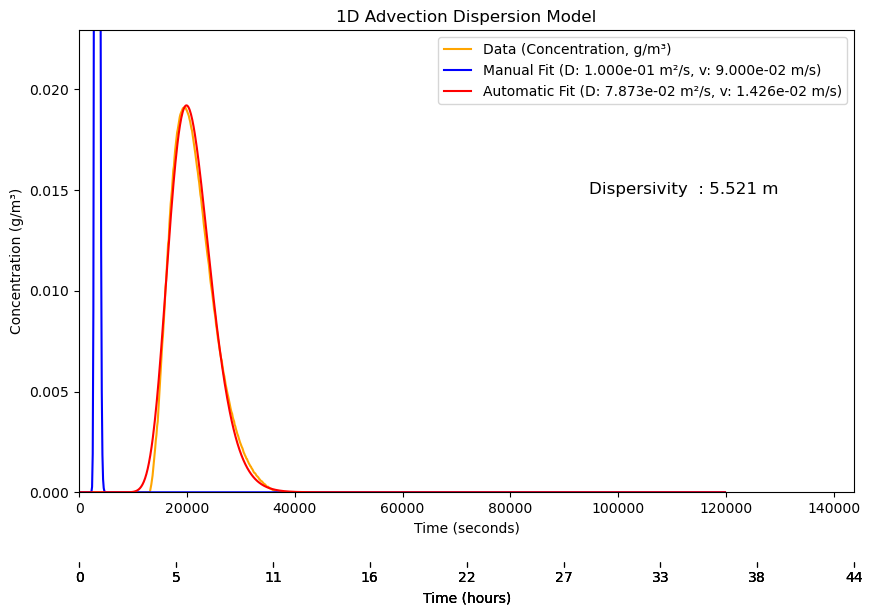

<Figure size 640x480 with 0 Axes>

In [103]:
path_to_data = 'calibration.csv'

# Parameter Eingabe (kann nachher noch geändert werden)
distance = 300  # m
mass_input_rate = 2.05  # g
flow_rate = 11e-3  # m^3/s

model = OneDimensionalAdvectionDispersionModel(path_to_data, x=distance, m_in=mass_input_rate, Q=flow_rate, secondary_axis='hours')
model.initial_plot()
model.create_interactive_plot()

### Explanation of the Code Below

The following code retrieves and compares the manually adjusted model, the fitted model, and the real data from the `OneDimensionalAdvectionDispersionModel`. Here’s a step-by-step explanation:

1. **Retrieve Manually Adjusted Model**:
    - `manual_adjusted_model = model.return_manual_adjusted_model()`: This retrieves the concentration values that were manually adjusted using the interactive sliders.

2. **Retrieve Fitted Model**:
    - `fitted_model = model.return_fitted_model()`: This retrieves the concentration values obtained by fitting the model to the real data using the automatic fitting process.

3. **Retrieve Real Data**:
    - `real_data = model.return_real_data()`: This retrieves the real concentration data from the CSV file.

After running these lines, you can compare the manually adjusted model and the automatically fitted model with the real data to see how well each method approximates the actual concentration values.

**Note**: Directly after clicking the "Fit Model" button, the plot will no longer be interactive. You can then run the following cells to compare how well the manual fit matches the real data compared to the automatic fit. The automatic fitting method requires an initial guess that is reasonably close to the true value for it to work effectively.


In [95]:
manual_adjusted_model = model.return_manual_adjusted_model()
fitted_model = model.return_fitted_model()
real_data= model.return_real_data()

### Explanation of the Code Below

The following code generates scatter plots to compare the actual concentration values with the predicted values from both the automatic and manual fits. This helps visualize how well each model fits the real data.

1. **Actual and Predicted Values**:
    - `y_actual = real_data['corr_conc']`: The actual concentration values from the real data.
    - `y_predicted_auto = fitted_model`: The concentration values predicted by the automatic fitting process.
    - `y_predicted_manual = manual_adjusted_model`: The concentration values predicted by the manual adjustments using the interactive sliders.

2. **Plot Configuration**:
    - The figure is divided into two subplots, one for each fit (automatic and manual).

3. **Scatter Plot for Auto Fit**:
    - The first subplot (left side) displays a scatter plot of the actual values (`y_actual`) against the predicted values from the automatic fit (`y_predicted_auto`).
    - A red line at a 45-degree angle is plotted to indicate perfect agreement between the actual and predicted values. Points falling along this line represent a perfect fit.

4. **Scatter Plot for Manual Fit**:
    - The second subplot (right side) displays a scatter plot of the actual values (`y_actual`) against the predicted values from the manual fit (`y_predicted_manual`).
    - Similarly, a red 45-degree line is plotted for reference.

These scatter plots help assess the performance of both the automatic and manual fits by showing how closely the predicted values match the actual values. Points closer to the 45-degree line indicate a better fit.

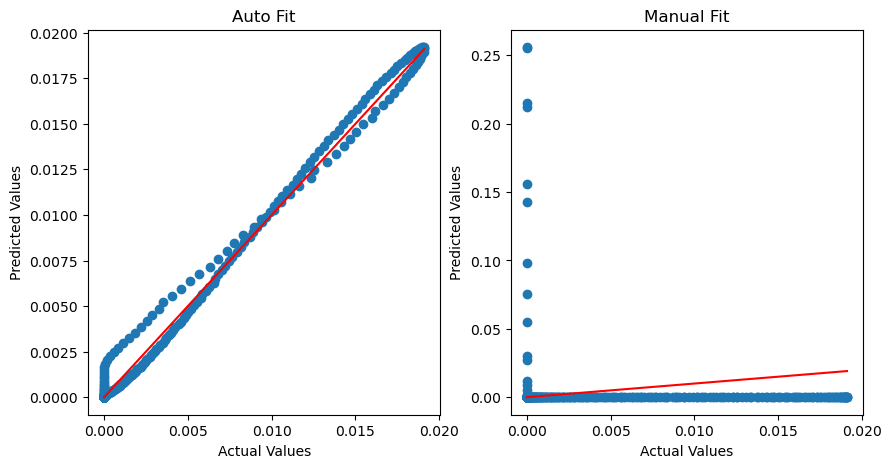

In [97]:
import matplotlib.pyplot as plt

# Assuming you have two lists: y_actual and y_predicted for both auto and manual fit
y_actual = real_data['corr_conc']
y_predicted_auto = fitted_model
y_predicted_manual = manual_adjusted_model

plt.figure(figsize=(10, 5))

# Plot for auto fit
plt.subplot(1, 2, 1)
plt.scatter(y_actual, y_predicted_auto)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Auto Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

# Plot for manual fit
plt.subplot(1, 2, 2)
plt.scatter(y_actual, y_predicted_manual)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Manual Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

plt.show()